# Building age-dependent longevity models
In this notebook we will describe the method for training a probablistic model for reaching the age of 85.  
The code below exemplifies the mldpEHR package which is used for training age-dependent multivariate prediciton models for longevity and disease.
The examples will use datasets available in the mldpEHR.data package.
                                    
                                                


## Setting up simulation data
The procedures demonstrated in this notebook will used a simulated dataset of patients stored mldpEHR.data dataset.  
The longevity simulated data consists of the following:
* longevity.patients - a list of data frames, one for each age, containing the entire population of patients
* longevity.features - a list of data frames, one for each age, containing the features to be used for training the prediction models.

In [1]:
# installing mldpEHR, and mdlrEHR.data
#remotes::install_github("tanaylab/mldpEHR")
#remotes::install_github("tanaylab/mldpEHR.data")

In [2]:
library(tidyverse)
library(mldpEHR)
library(mldpEHR.data)
names(longevity.patients)
head(longevity.patients[["80"]])

-- Attaching packages --------------------------------------- tidyverse 1.3.1 --

v ggplot2 3.4.0      v purrr   0.3.5 
v tibble  3.1.8      v dplyr   1.0.10
v tidyr   1.2.1      v stringr 1.4.1 
v readr   2.1.3      v forcats 0.5.1 

-- Conflicts ------------------------------------------ tidyverse_conflicts() --
x dplyr::filter() masks stats::filter()
x dplyr::lag()    masks stats::lag()



[1] "80" "75" "70" "65" "60" "55" "50"

,id,time,age,sex,death,has_cbc,followup
,<dbl>,<date>,<dbl>,<dbl>,<dbl>,<lgl>,<dbl>
1,967467,2020-11-09,80,1,NA,TRUE,0.1452055
2,967468,2020-02-28,80,1,NA,TRUE,0.8438356
3,967496,2020-04-23,80,1,NA,TRUE,0.6931507
4,967499,2020-05-13,80,1,NA,TRUE,0.6383562
5,967504,2020-04-30,80,1,NA,TRUE,0.6739726
6,967513,2020-04-03,80,1,NA,TRUE,0.7479452


### defining model parameters

In [3]:
SURVIVAL_YEARS <- 5
STEP <- 5
MAX_MISSING_PER_FEATURE <- 0.8
FOLDS <- 5

## Building longevity models
For each age, we will build a classification model for patient survival to age>= 85. 
As our followup time is limited, we will use older age model score to define the target classification for the younger age model, basically stitching these models together.
The data we need to provide consists of the entire popultation at each given age along with their sex, age, age at death and potential followup time (time until the end of the database).




In [4]:
longevity <- mldpEHR.mortality_multi_age_predictors(longevity.patients, longevity.features, step=5, nfolds=5, required_conditions='has_cbc')

### Looking at feature significance



In [5]:
features_sig <- purrr::map(longevity, ~ mldpEHR.prediction_model_features(.x)$summary %>% arrange(desc(mean_abs_shap)))
head(features_sig[[1]])

,feature,mean_abs_shap
,<chr>,<dbl>
ALBUMIN,ALBUMIN,0.2641493
RDW,RDW,0.1334548
UREA,UREA,0.1217083
sex,sex,0.1212199
ALT,ALT,0.1089143
CPK,CPK,0.1055787


Warning message:
"Removed 5112 rows containing missing values (`geom_point()`)."


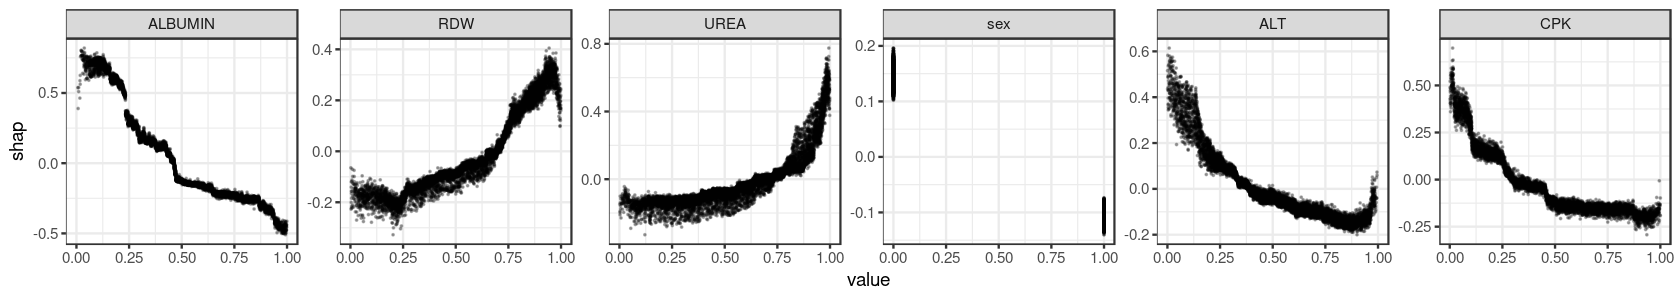

In [6]:
N_PATIENTS <- 10000
shap_features_80 <- mldpEHR.prediction_model_features(longevity[["80"]])$shap_by_patient %>% 
                             filter(feature %in% head(features_sig[["80"]] %>% pull(feature))) %>% 
                             group_by(feature) %>% 
                             sample_n(N_PATIENTS) %>% 
                             ungroup %>% 
                             mutate(feature=factor(feature, levels=head(features_sig[["80"]] %>% pull(feature))))
options(repr.plot.width=14, repr.plot.height=2.5)
ggplot(shap_features_80, aes(x=value, y=shap)) + geom_point(size=0.01, alpha=0.3) + facet_wrap(~feature, nrow=1, scales="free_y") + theme_bw()

## Computing Markovian probability model


In [7]:
longevity_markov <- mldpEHR.mortality_markov(longevity, SURVIVAL_YEARS, STEP, seq(0, 1, by=0.1), required_conditions=glue::glue("time >= as.Date('2005-01-01') & time < as.Date('2016-01-01')"))


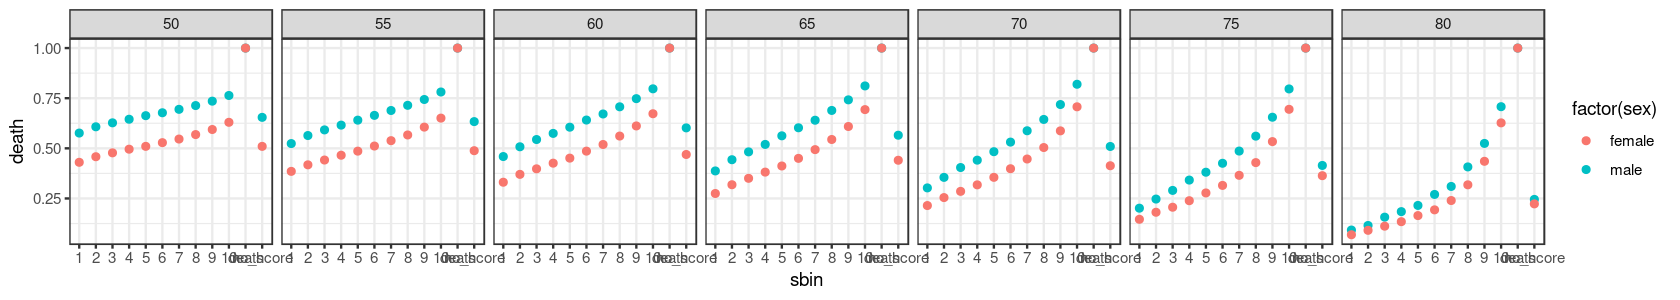

In [8]:
longevity_prob <- purrr::map2_df(longevity_markov, names(longevity_markov), ~ as_tibble(.x$model[[1]], rownames='sbin') %>% mutate(sex='male', age=.y) %>% bind_rows(as_tibble(.x$model[[2]], rownames='sbin') %>% mutate(sex='female', age=.y)))
options(repr.plot.width=14, repr.plot.height=2.5)
ggplot(longevity_prob %>% mutate(sbin=factor(sbin, levels=c(1:10, "death", "no_score"))), 
       aes(x=sbin, y=death, colour=factor(sex))) + geom_point() + facet_grid(.~age) + theme_bw()

# Build a disease model for diabetes
similar to longevity, will used simulated diabetes data, found in mldpEHR.data dataset:
* diabetes.patients - a list of data frames, one for each age, containing the entire population of patients
* diabetes.features - a list of data frames, one for each age, containing the features to be used for training the prediction models.


In [9]:
diabetes <- mldpEHR.disease_multi_age_predictors(diabetes.patients, diabetes.features, step=5, nfolds=5, required_conditions='has_cbc')

##Looking at feature significance

In [10]:
features_sig <- purrr::map2(diabetes, names(diabetes), ~ mldpEHR.prediction_model_features(.x)$summary %>% mutate(age=.y) %>% 
                            arrange(desc(mean_abs_shap)))
head(features_sig[[1]])


,feature,mean_abs_shap,age
,<chr>,<dbl>,<chr>
GLUCOSE,GLUCOSE,0.96548184,80
HA1C,HA1C,0.15981877,80
NON-HDL_CHOLESTEROL,NON-HDL_CHOLESTEROL,0.09317289,80
GLOBULIN,GLOBULIN,0.09128647,80
BMI,BMI,0.08881937,80
CREATININE,CREATININE,0.08012901,80


Warning message:
"Removed 4653 rows containing missing values (`geom_point()`)."


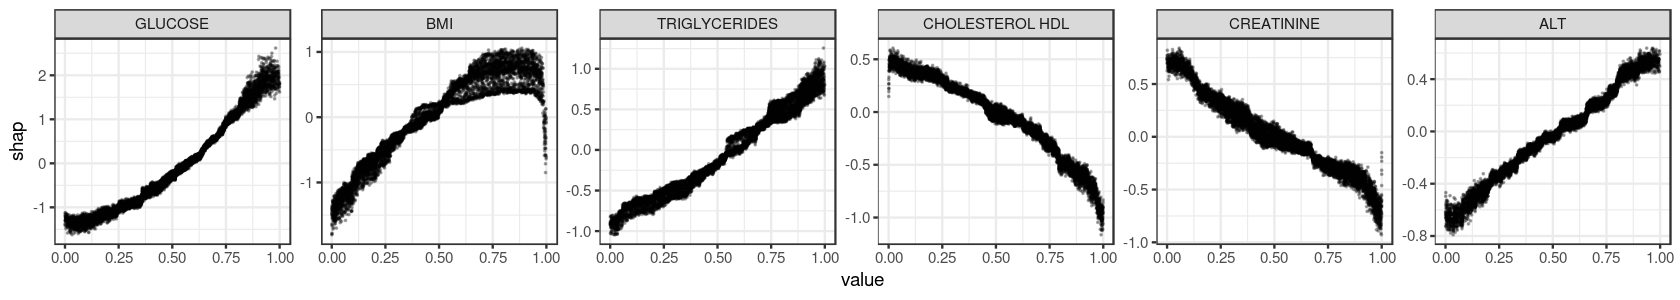

In [11]:
N_PATIENTS <- 10000
shap_features_50 <- mldpEHR.prediction_model_features(diabetes[["50"]])$shap_by_patient %>% 
                             filter(feature %in% head(features_sig[["50"]] %>% pull(feature))) %>% 
                             group_by(feature) %>% 
                             sample_n(N_PATIENTS) %>% 
                             ungroup %>% 
                             mutate(feature=factor(feature, levels=head(features_sig[["50"]] %>% pull(feature))))
options(repr.plot.width=14, repr.plot.height=2.5)
ggplot(shap_features_50, aes(x=value, y=shap)) + geom_point(size=0.01, alpha=0.3) + facet_wrap(~feature, nrow=1, scales="free_y") + theme_bw()

In [12]:
## Computing Markovian probability model

In [13]:
diabetes_markov <- mldpEHR.disease_markov(diabetes, 5, 5, seq(0, 1, by=0.1), required_conditions=glue::glue("time >= as.Date('2005-01-01') & time < as.Date('2016-01-01')"))

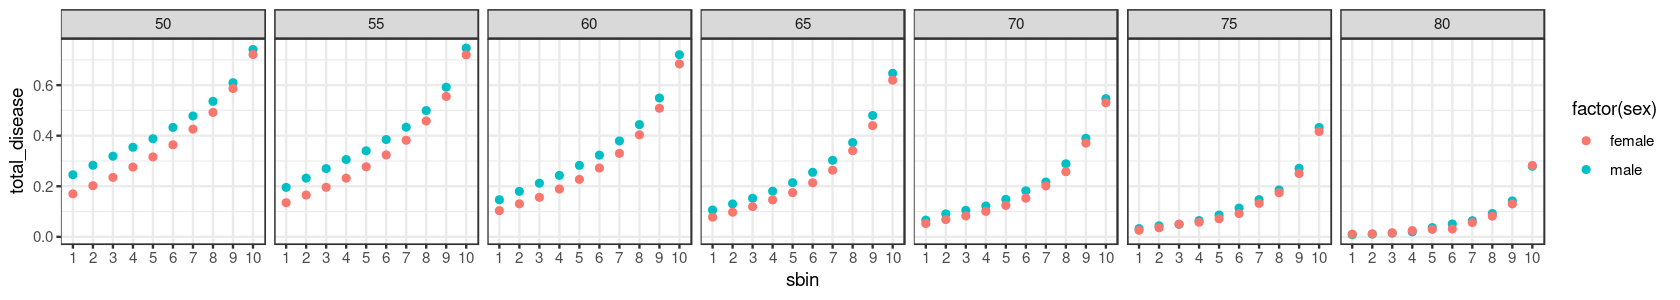

In [14]:
diabetes_prob <- purrr::map2_df(diabetes_markov, names(diabetes_markov), ~ 
    as_tibble(.x$model[[1]], rownames='sbin') %>% mutate(sex='male', age=.y) %>% 
    bind_rows(
        as_tibble(.x$model[[2]], rownames='sbin') %>% mutate(sex='female', age=.y))
    ) %>% 
    mutate(sbin=factor(sbin, levels=c(1:10, "disease", "disease_death", "death", "no_score")),
          total_disease=disease+disease_death)
options(repr.plot.width=14, repr.plot.height=2.5)
ggplot(diabetes_prob %>% filter(as.numeric(sbin) <= 10), aes(x=sbin, y=total_disease, colour=factor(sex))) + geom_point() + facet_grid(.~age) + theme_bw()

In [15]:
shap <- mldpEHR.prediction_model_features(diabetes[["50"]])

In [16]:
head(shap$shap_by_fold)

,fold,id,sex,WBC,RBC,HGB,HCT,PLT,MCV,MCH,⋯,FOLIC ACID,GLOBULIN,NON-HDL_CHOLESTEROL,FERRITIN,TSH,T4 FREE,BMI,BP SYSTOLIC,BP DIASTOLIC,BIAS
,<fct>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,1,1,0.2523467,-0.02487233,0.06180592,0.06173039,0.001842315,-0.008975940,-0.0274398495,0.0013276532,⋯,0.002132911,0.03006584,0.004185709,0.04380948,-0.019279752,0.006839546,-1.323644,0.13072027,0.035614271,-0.6536388
2,2,1,0.2772871,-0.05033518,0.04164337,0.03500469,-0.005127913,-0.011284989,-0.0213765651,-0.0261953361,⋯,-0.003201672,0.03382161,0.005486948,0.03869656,-0.018252173,0.013939313,-1.355202,0.12744655,0.030342715,-0.6511232
3,3,1,0.2001412,-0.01208779,0.05610102,0.03706371,0.006366817,-0.003154173,-0.0262789093,-0.0045678602,⋯,-0.002863556,0.04699297,0.023726847,0.03983758,-0.012896349,0.013132541,-1.484894,0.09294418,-0.007187250,-0.6534403
4,5,1,0.2484475,-0.03974956,0.05934383,0.03510357,-0.002895946,-0.016887080,-0.0361955725,0.0004802126,⋯,-0.001769888,0.02224203,-0.009963578,0.03938646,0.002927497,0.012042018,-1.220531,0.18412912,0.025309263,-0.6487635
5,1,2,0.2709689,0.14031480,-0.11093173,-0.02351592,-0.003534155,0.009864728,-0.0081585525,0.0030479573,⋯,-0.013154480,-0.04122223,-0.001037552,-0.09508873,-0.041288048,-0.025651010,-1.301617,-0.23382096,0.010248748,-0.6536388
6,2,2,0.2869865,0.08529719,-0.08143875,-0.03048725,-0.005592946,0.004758276,-0.0007563605,-0.0196335968,⋯,0.011931754,-0.05018238,0.005825588,-0.07780322,-0.093282156,-0.043640122,-1.261442,-0.29313573,-0.003206228,-0.6511232


In [17]:
nrow(shap$shap_by_fold)

[1] 1104992